# JPEG compression with Rate-Distortion Optimised Quantisation (RDOQ)
This tutorial continues the journey of improving the JPEG compression standard, this time by leveraging on the quantisation process. Indeed, as it is well-known the standard only mandates on the legal value range each transform coefficient should have but not how its value is obtained. As such, the encoder is free to play with how the coefficients are quantised, in order to minimise a given rate-distortion cost.

In the following we will start with some preliminary remarks to review concepts such as rate-distortion optimisation using the Lagrangian method and a practical approach to select the Lagrange multiplier. We will then move to describe how Rate-Distortion Optimised Quantisation (RDOQ) works and in particular how it can be applied to the JPEG's compression workflow.

As usual, it is assumed that the reader is familiar with the basic concepts of quantisation and entropy coding specified in the JPEG compression format. More details have been provided in this other [tutorial](./jpeg-baseline.ipynb) and additionally in these classical text books:
 * W. B Pennebaker and J. L. Mitchell, "JPEG: Still image data compression standard", Kluwer Academic Publishers, 638 pages, 1992.
 * David S. Taubman and Micheal W. Marcellin, "JPEG 2000: Image compression fundamentals, standards and practice", Kluwer Academic Press, 773 pages, 2002.

Moreover, a comprehensive overview on Rate-Distortion Optimisation (RDO) applied to image and video coding is available from this very good survey paper:
 * G. J. Sullivan and T. Wiegand, "Rate-distortion optimization for video compression", IEEE Signal Processing Magazine, vol. 15, no 6, pp. 74-90, November 1998, https://doi.org/10.1109/79.733497.

## Rate-distortion optimisation framework
We already mentioned that an encoder compliant with the JPEG compression standard can select the final value for each quantised transform coefficient, so that a given rate distortion cost is minimised. As an example, consider the following sequence of values - ordered in zigzag scanning - resulting from the quantisation of a $8\times8$ block with a given quantisation table.

<img src="quantised-values-example.png" alt="Example of block values resulting from the quantisation process" width="500"/>

We notice that the sequence of zero values starting at the third coefficient is interrupted by the seventh quantised coefficient: it may be the case that the additional distortion associated with setting the value for this coefficient to zero is compensated for by the rate saved due to the creation of a longer run of zeros. When the distortion increase is less than the rate saved, the overall rate-distortion cost for a given $8\times8$ block is less than its original starting value, i.e. when the seventh coefficient had a non zero value. We can continue our preliminary considerations by observing that even the final value for End Of Block ([EOB](./jpeg-baseline.ipynb)) can be negotiated as long as the overall distortion increase is compensated by the reduced coding rate obtained.

From these initial intuitions, we need to take a step forward and formalise our problem so that it can be systematically addressed. Let $\{l\}_i$ be the set of possible quantised levels assumed by the $i$-th coefficient. Each of these levels, say $l$, is then associated with a distortion $D_{l}$ and requires $R_l$ bits to encode. What we're looking for is to minimise the overall block distortion over the set of possible level values for all coefficients and not exceed a given block-based rate budget, denoted as $R$. Formally this translates into:

$$
\left\{\begin{aligned}
\min_{l\in\{l\}_i} & \sum_i D_l\\
s.t. & \sum_i R_l \leq R \\
\end{aligned}
\right..
$$

In the constrained optimisation problem formulation above we implicitly assumed that 1) our distortion measure is coefficient-based and additive as well as 2) that its value in the transform domain is the same as in the spatial (i.e. pixel) domain. The second point is easily guaranteed by the use of a orthonormal frequency transformation (such as the DCT) so that the Parseval's theorem holds. The first point is tricker and indeed can open a whole Pandora vase. In fact, it is well-known that the human eye doesn't perceive coding artefacts (i.e. the distortion) uniformly and linearly across the whole image/video. In light of this phenomenon, plenty of perceptual distortion measures have been proposed in the literature. The large majority of these proposals use nonlinear combinations of pixel- and frequency-based features which would turn encoder tools such as RDOQ hard to design. To address this potentially complex problem, a simple, additive and quadratic distortion measure is adopted in our proposal. Doubtless it doesn't come as a surprise to the reader, the distortion measure chosen is the well-known Mean Square Error (MSE). Beside being additive, the MSE also has the advantage of being convex so that each (simple) convex optimisation tool can be used as well as its computation in practical image and video codes can be accomplished very efficiently.

Now that we sorted the distortion measure out, we can look again at our constrained optimisation problem and observe that being our distortion measure and constraint functions $\in C^1$, the [Lagrange multiplier method](https://en.wikipedia.org/wiki/Lagrange_multiplier) can be applied to transform our constrained optimisation problem into an unconstrained one, whereby the following cost function $J$ is minimised:

$$
\min_{l\in\{l\}_i} \left(J\right) = \min_{l\in\{l\}_i}\left(\sum_i D_l + \lambda\cdot \sum_i R_l\right),
$$

being $\lambda$ the Lagrange multiplier.

## Selection of the Lagrange multiplier value
All the Lagrange multiplier method cares about is to guarantee that the optimal solution for the cost function $J$ is also the same for the constrained optimisation problem. Hence, the Lagrange's theorem does not advise on which value should be chosen for $\lambda$. For the case of image/video coding and MSE as distortion measure, we known that the minimum can easily be obtained by setting the first order derivative of $J$ to zero. Accordingly, we can write:

$$
\frac{\partial J}{\partial R} = \frac{\partial D}{\partial R} + \lambda = 0 \Rightarrow \lambda = -\frac{\partial D}{\partial R},
$$

from the above we can see that the Lagrange multiplier is the tangent to the rate-distortion curve associated with the image/video codec. The following picture shows an example of RD curve with its tangent (i.e. the Lagrange multiplier) for different operating points (i.e. different coding rates).

<img src="rd-curve-lambda.png" alt="Rate-distortion curve and its associated Lagrange multiplier value" width="800"/>

In the figure $\sigma_I$ denotes the variance of the whole image, obtained when zero bits are used to encode it and $H_I$ is instead the image's entropy, attained when the no quantisation is used to encoder it, hence just lossless coding is employed. For all coding rates between zero and $H_I$, a different rate-distoriton trend is obtained. We notice that the tangent to the curve has values larger than one for lower coding rates, meaning that the cost $J$ favours more rate reductions than distortion's. Conversely, for high coding rates the Lagrange multiplier is rather small and distortion variations are favoured. From these considerations we see that $\lambda$ must be a function of the coding rate. Moreover, being the coding rate related to the value of the quantisation step $Q$ used by the encoder, we can easily understand that:

$$
\lambda = \lambda(Q).
$$

The work from [Wiegand and Girod](https://ieeexplore.ieee.org/document/958171) proposes to use a quadratic relationship for the value of $\lambda$ in the form of:

$$
\lambda = c\cdot Q^2,
$$

where $c$ is a constant that depends on the source's statistics and it was set to 0.85 for the H.263 standard and instead assumes the value of 0.57 in the reference implementation of the H.265/HEVC standard (i.e. the HM code base). A quadratic relationship is a *good enough* model when an image/video codec is operating in the so-called high resolution regime (i.e. at high coding rates) where the distortion can be approximated as:

$$
D = \frac{Q^2}{12}.
$$

For different operating conditions, better relationships can be used such as the one proposed in this [work](https://ieeexplore.ieee.org/document/4284662). To keep things simple, in this tutorial we will also be using the quadratic relationship proposed by Wiegand and Girod and adapt $\lambda$ to the selected quantisation tables. The value of $c$ is set to 0.1 since a quick experimental investigation revealed it as a good fit to rate-distortion curves associated with the JPEG compression standard encoder designed in this tutorial. It is acknowledge that more exhaustive experiments, like the one described in Wiegand's and Girod's work, are required to find out a value for $c$ more suitable for a large class of test images.

## Modelling rate distortion optimised quantisation
RDOQ is often referred as trellis coded quantisation, a technique inspired by trellis coding modulation from the digital communication community. The idea in trellis coded quantisation is to assign for each coefficient a set of states corresponding to a given quantisation level value. These sets of states can then be arranged in sequence, given that transform coefficients in an $8\times8$ block are entropy encoded according to the zigzag scanning. States of adjacent transform coefficients are then connected with edges, each labelled with the associated rate-distortion cost. The whole graph resembles a trellis (hence the name trellis coded quantisation) as depicted in the following figure.

<img src="trellis-example.png" alt="Trellis generated for all 64 transform coefficients of JPEG block" width="1000"/>

To avoid over complicating the figure, the levels $l_0, l_1, \dots$ for each coefficients are assumed to be different, although they are denoted with the same symbols. Moreover, due to run length encoding, each state should also be labelled with the associated run length. Again this is omitted for the sake of a cleaner drawing. Rate-distortion costs $J_{0,0}, J_{0,1}, \dots$ denote the resulting rate-distortion variations when encoding two adjacent transform coefficients with the level indices associated with the subscript of the cost $J$.

One may appreciate as rate-distortion optimised quantisation (alis trellis coded quantisation) can lead to a fairly high computational complexity, since all possible combinations *coefficient-level* need to be considered. Such a complexity can be skimmed down by applying the well-known [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm) which allows, for each state associated with a given coefficient, to discard all trellis' branches which do not lead to rate-distortion cost minimisation. The branches/edges which lead to minimisation are denoted as *surviving paths*. The sequence of all surviving paths from the DC coefficient to 63-th AC coefficient is called Viterbi path and denoted with the black thick line in the figure above. Once the Viterbi's path is available, RDOQ can output the set of quantisation levels assigned for each transform coefficient. We recall from our initial discussion that even the EOB position can be included in the whole optimisation process. Its optimisation can be either accomplished by evaluating for each coefficient the additional distortion brought by stopping the encoding at the current coefficient's position. Such an approach would however require to known the rate-distortion cost of the whole $8\times8$ block, hence perform a sort of two pass encoding. Alternatively, the EOB's optimisation can be accomplished as a second stage, after the Viterbi path is available so that no additional passes are required.

We are now in a position to design the actual RDOQ for our JPEG encoder. This is the subject of the following section.

## RDOQ design
One key aspect to address in the design of our algorithm is how many states each transform coefficient should be allocated on the trellis. The actual quantisation operated with the tables selected would restrict the range of possibilities, given that if a transform coefficient has small magnitude and we're operating at low coding rates, there is no much point in trying some additional values other than 0 and possibly $\pm 1$.

For transform coefficients associated with non zero levels, the range may be restricted according to the following two observations:
 1. If the level's magnitude $|l|$ is $\gg 1$ then only $|l| - 1$ and (maybe) $|l| - 2$ are worth considering, since magnitudes too far away from the original value would lead to high distortion and are unlikely to minimise the rate-distortion cost
 1. Even if $|l|$ is large, setting its value to zero may lead to a good rate decrease associated with the continuation of the run, just interrupted by $|l|$.

In light of the above considerations, the design will consist of a three phase approach:
 1. Phase 1: Rate-distortion cost optimisation for the level associated with the DC coefficient
 1. Phase 2: Rate-distortion cost optimisation for all AC coefficients
 1. Phase 3: Search for the best EOB position so that the block's rate-distortion cost is further minimised

During the first two phases two additional quantisation levels will be tried for each coefficient, i.e. $|l| - 1$ and zero. We will review the implementation of each phase in the following Python code cells. We start with the definition of some input coefficients, Lagrange multiplier, quantisation tables and the Huffman tables needed to compute the coding rate.

In [1]:
# Definition of the algorithm's inputs
import numpy as np
from entropy import (expand_huffman_table,
                     get_zigzag_scan, luma_ac_bits, luma_ac_values,
                     luma_dc_bits, luma_dc_values)

coefficients = np.array([[-320.62, -85.82, -100.15, -84.02, -83.62, -56.78, -33.07, -16.53],
                         [-70.46, 17.94, 7.28, 11.05, 14.25, 3.55, 0.07, 2.68],
                         [-81.56, 9.43, 14.78, 18.86, 11.11, 10.14, -2.49, 1.23],
                         [-62.03, 8.17, 11.23, 3.48, 15.48, 7.01, 8, -0.56],
                         [-55.88, 10.99, 3.27, 6.23, 10.62, 5.98, 14.75, 6.25],
                         [-52.31, 3.16, 11.31, 4.98, 13, 6.84, 5.04, -0.09],
                         [-31.3, 8.82, 7.26, 6.05, -0.95, 1.43, -3.78, 13.38],
                         [-11.69, 3.65, 5.07, 0.21, -0.69, 4.46, -1.18, -7.26]])

qm = np.array([[ 14,  10,   9,  14,  22,  36,  46,  55],
               [ 11,  11,  13,  17,  23,  52,  54,  50],
               [ 13,  12,  14,  22,  36,  51,  62,  50],
               [ 13,  15,  20,  26,  46,  78,  72,  56],
               [ 16,  20,  33,  50,  61,  98,  93,  69],
               [ 22,  32,  50,  58,  73,  94, 102,  83],
               [ 44,  58,  70,  78,  93, 109, 108,  91],
               [ 65,  83,  86,  88, 101,  90,  93,  89]], dtype=np.int32)

table_dc = expand_huffman_table(luma_dc_bits, luma_dc_values)
table_ac = expand_huffman_table(luma_ac_bits, luma_ac_values)
_lambda = 0.1 * np.mean(qm)**2
r_zz_idx, zz_idx = get_zigzag_scan(8)
zz_idx = zz_idx.flatten()
pred_dc = 0

We then perform the first phase of the algorith, i.e. the rate-distortion cost optimisation for the DC coefficient. We recall from the JPEG compression standard that the DC coefficient is encoded using Differential Pulse Code Modulation (DPCM). If the prediction residual is zero, then there is no much else to do, given that the distortion is the minimum attainable (given the quantisation table divisor) and also the associated codeword is going to have the minimum lenght. If instead the DPCM prediction residual is not zero, then the set of levels mentioned above will be evaluated and the one with the minimum rate-distortion cost will be selected.

In [2]:
# Regular quantisation
s = np.sign(coefficients).astype(np.int32)
levels = np.divide(coefficients + 0.5, qm).astype(np.int32)

# Coefficient-based rate and distortion storage
distortion0 = np.square(coefficients).flatten()[zz_idx]
distortion_coeff = np.square(coefficients).flatten()[zz_idx]
rate_coeff = np.zeros((64), np.int32)

# Apply DPCM for the DC coefficient
res_dc = levels[0, 0] - pred_dc

# Phase 1: Optimise the RD cost for the DC coefficient
if not res_dc:
    # Zero value residual, no quantisation distortion, just add the rate
    rate = table_dc[0, 1]
    rate_coeff[0] = table_dc[0, 1]
    distortion_coeff[0] = (coefficients[0, 0] - levels[0, 0] * qm[0, 0])**2
    distortion = distortion_coeff[0]
else:
    # Perform RDO: test the current DC value, zero and its absolute value minus one
    best_rd_cost = np.finfo(np.float64).max
    sign_dc = s[0, 0]
    abs_dc = np.abs(levels[0, 0])
    candidates = np.unique([0, abs_dc, abs_dc - 1])
    for current_lev in candidates:
        current_dist = (coefficients[0, 0] - sign_dc * current_lev * qm[0, 0])**2
        res_dc = sign_dc * current_lev - pred_dc
        if res_dc:
            res_dc_category = int(np.ceil(np.log2(np.abs(res_dc) + 1)))
            current_rate = table_dc[res_dc_category, 1] + res_dc_category
        else:
            current_rate = table_dc[0, 1]
        rd_cost_current = current_dist + _lambda * current_rate
        if rd_cost_current < best_rd_cost:
            best_rd_cost = rd_cost_current
            rate = current_rate
            rate_coeff[0] = current_rate
            distortion = current_dist
            levels[0, 0] = sign_dc * current_lev
            distortion_coeff[0] = current_dist

We can now move to the second phase of our RDOQ design, whereby for the AC transform coefficients three different level values are considered: the one resulting from regular quantisation, the level whose absolute value differs by one compared to the regular's and zero, implying that whichever run of zeros is associated with the current coefficient, is going to be extended to the next non zero level. To implement the workflow for this second phase, we will be using a helper function (`rd_rl_pair`) which computes the rate-distortion cost given a 1D array of transform coefficients and a position in the array where the cost calculation should start from. Besides the rate-distortion cost, the function also returns the length of the run of zeros. Being a helper function, its processing is limited and therefore it is down to the RDOQ machinery to provide the right inputs and change the quantisation levels accordingly. At high level, the second phase of RDOQ may be summarised with the following Python style pseudo-code:

```Python
i = 1
while i <= eob_position:
    # Rate-distortion cost for the current quantisation level
    cost, run_length = rd_rl_pair(i, levels, ac_huffman_table)

    # Rate-distortion cost when the magnitude of quantisation level is decreased by one
    temp = levels[i]
    levels[i] = sign(levels[i]) * (abs(levels[i]) - 1)
    cost_m1, run_length = rd_rl_pair(i, levels, ac_huffman_table) # The length of the run is the same here
    if cost_m1 < cost:
        best_rd_cost = cost_m1
    else:
        best_rd_cost = cost
        levels[i] = temp

    # Rate-distortion cost when the quantisation level is set to zero
    cost_next, run_length_next = rd_rl_pair(i + run_length, levels, ac_huffman_table)
    temp = levels[i]
    levels[i] = 0
    cost0, run_length0 = rd_rl_pair(i, levels, ac_huffman_table)
    if best_rd_cost + cost_next < cost0:
        levels[i] = temp
        i += run_length + 1
```

We note how during the evaluation of the zero level we need to consider also the following run length pair. This is because the optimisation in this case is between the case of sending two separated codewords for the current and following run length value pair *or* sending a single codeword associated with the extended run length. The following picture depicts the choice.

<img src="run-length-zero.png" alt="Rate-distortion cost comparison when the current run is extended" width="1000"/>

In [3]:
from typing import Tuple
from nptyping import NDArray

def rd_rl_pair(start: int, coefficients_zz: NDArray[(64), np.float64], levels_zz: NDArray[(64), np.int32],
               qm_zz: NDArray[(8, 8), np.float64], ht: NDArray[(256, 2), np.int32]) -> Tuple[int, float, float, int]:
    i, run_length = start, 0
    distortion = 0
    while levels_zz[i] == 0:
        run_length += 1
        distortion += coefficients_zz[i]**2
        i += 1

    distortion_value = (coefficients_zz[i] - levels_zz[i] * qm_zz[i])**2
    distortion += distortion_value
    category = int(np.ceil(np.log2(np.abs(levels_zz[i]) + 1)))
    rlv_pair = ((run_length & 15) << 4) | category
    rate = ht[rlv_pair, 1] + category + (run_length >> 4) * ht[15 << 4, 1]

    return rate, distortion, distortion_value, run_length

In [4]:
# Find the eob
levels_zz = levels.flatten()[zz_idx]
idx = np.where(levels_zz[-1:0:-1] != 0)
last_sig_coeff = 63 - idx[0][0] if len(idx[0]) else 0

# RDO for the AC coefficients
coefficients_zz = coefficients.flatten()[zz_idx]
qm_zz = qm.flatten()[zz_idx]
s_zz = s.flatten()[zz_idx]

# Phase 2: Try different level values for each AC coefficient and pick the one which
# minimimise its RD cost
rate_eob = table_ac[0, 1]
i = 1
while i <= last_sig_coeff:
    # RD cost for the current quantised level
    rq, dq, dsq, rlq = rd_rl_pair(i, coefficients_zz, levels_zz, qm_zz, table_ac)
    rd_costq = dq + _lambda * rq
    distortion_coeff[i + rlq] = dsq
    rate_coeff[i + rlq] = rq
    rd_cost = rd_costq

    # RD cost for |level| - 1
    lq = levels_zz[i + rlq]
    if np.abs(lq) > 1:
        lq_m1 = s_zz[i + rlq] * (np.abs(lq) - 1)
        levels_zz[i + rlq] = lq_m1
        rq_m1, dq_m1, dsq_m1, _ = rd_rl_pair(i, coefficients_zz, levels_zz, qm_zz, table_ac)
        rd_costq_m1 = dq_m1 + _lambda * rq_m1
        if rd_costq_m1 < rd_costq:
            distortion_coeff[i + rlq] = dsq_m1
            rate_coeff[i + rlq] = rq_m1
            rd_cost = rd_costq_m1
        else:
            levels_zz[i + rlq] = lq

    # RD cost for level zero
    if i + rlq != last_sig_coeff:
        rqn, dqn, _, _ = rd_rl_pair(i + rlq + 1, coefficients_zz, levels_zz, qm_zz, table_ac)
        rd_costn = dqn + _lambda * rqn
        lq = levels_zz[i + rlq]
        levels_zz[i + rlq] = 0
        rq0, dq0, dsq0, rlq0 = rd_rl_pair(i, coefficients_zz, levels_zz, qm_zz, table_ac)
        rd_cost0 = dq0 + _lambda * rq0

        if rd_cost0 < rd_cost + rd_costn:
            rate_coeff[i + rlq0] = rq0
            distortion_coeff[i + rlq0] = dsq0
            distortion_coeff[i + rlq] = distortion0[i + rlq]
            rate_coeff[i + rlq] = 0
            if i + rlq0 == last_sig_coeff:
                break
        else:
            levels_zz[i + rlq] = lq
            i += rlq + 1
    else:
        break

distortion = np.sum(distortion_coeff)
rate = np.sum(rate_coeff)

The information associated with the Viterbi path is stored in the `distortion_coeff` and `rate_coeff` arrays which are going to be used in the third phase of RDOQ. The processing will visit the Viterbi path data in the reverse direction and look for each position of a non zero level whether it would lead to a better rate-distortion cost than the one obtained so far. Worth noting that as the processing move back towards the DC coefficient, the cumulative rate and distortion values need updating so they reflect the actual cost as if the block encoding stopped at any given position.

In [5]:
# # Phase 3: Move the EOB towards the block's top left corner
i = last_sig_coeff
best_eob = last_sig_coeff + 1
rate += rate_eob
distortion_now, rate_now = distortion, rate
cost_best = distortion + _lambda * rate
if last_sig_coeff == 63:
    cost_best -= _lambda * rate_eob

while i > 0:
    if levels_zz[i]:
        # Adjust the rate and distortion
        distortion_now += distortion0[i] - distortion_coeff[i]
        rate_now -= rate_coeff[i]
        cost_now = distortion_now + _lambda * rate_now
        if cost_now < cost_best:
            best_eob = i
            cost_best = cost_now
            distortion, rate = distortion_now, rate_now
    i -= 1

levels_zz[best_eob:] = 0

levels_rdoq = np.reshape(levels_zz[r_zz_idx], (8, 8))

Over the input data our RDOQ has provided a block whose levels differ from the original ones: some have their magnitude reduced by one some others has been set to zero, hence expanding the associated run of zeros. The following Python code cell shows the 2D arrays associated the levels and the optimised ones as well as their rate-distortion costs, showing that indeed minimisation took place and improved the cost by 4%. The implementation described in the previous Python code cell has been added as the `rdoq_8x8_plane` function to the `quantiser.py` package. This function will be used to perform RDOQ in the modified JPEG encoder described in the following section. Finally, worth noting that the `rdoq_8x8_plane` may be equipped with assertions during the processing to debug (for example) that the rate stored in the `rate_coeff` array equates the value returned by the function `encode_block` from the `entropy.py` package (remember to add the bits associated with the EOB to the sum from `rate_coeff`) or that the actual rate-distortion cost at the end of RDOQ is either decreased or didn't change.

In [6]:
from entropy import encode_block
print("Levels from plain quantisation")
print(levels)
print("\nLevels after RDOQ")
print(levels_rdoq)
_, rate_base = encode_block(levels.flatten()[zz_idx], pred_dc, table_dc, table_ac)
rd_cost_base = np.sum(np.square(coefficients - levels * qm)) + _lambda * rate_base
print(f"\nRate-distortion cost plain quantisation: {rd_cost_base:.2f}, RDOQ: {cost_best:.2f}, improvement: {100*(rd_cost_base - cost_best) / rd_cost_base:.2}%")

Levels from plain quantisation
[[-22  -8 -11  -5  -3  -1   0   0]
 [ -6   1   0   0   0   0   0   0]
 [ -6   0   1   0   0   0   0   0]
 [ -4   0   0   0   0   0   0   0]
 [ -3   0   0   0   0   0   0   0]
 [ -2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]

Levels after RDOQ
[[-22  -7 -11  -5  -3  -1   0   0]
 [ -6   1   0   0   0   0   0   0]
 [ -6   0   0   0   0   0   0   0]
 [ -3   0   0   0   0   0   0   0]
 [ -3   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]

Rate-distortion cost plain quantisation: 32092.14, RDOQ: 30770.85, improvement: 4.1%


## Coding efficiency analysis
It's now time to understand how much the compression efficiency can be improved by using RDOQ. For this,  the `jpeg_encoding_rdoq` function encodes an input image in the YCbCr colour space using RDOQ. Over different images and quality values, the rate and distortion values obtained can be compared with the ones associated with the same encoding workflow which does not use RDOQ. Rather than plotting the distortion (i.e. the MSE), we would convert its value into the Peak-Signal-to-Noise-Ratio (PSNR) so to have a quality-like measure expressed in decibel (dB). Moreover, as common practive in the image and video coding community, the coding efficiency will be expressed using the well-known Bjotegaard Delta on the rate ([BD-rate](https://ottverse.com/what-is-bd-rate-bd-psnr-calculation-interpretation/)), a measure indicating the percentage of coding rate that can be saved by one codec for the same quality measure value of the reference codec, also denoted as the *anchor* codec.

In terms of experimental conditions, the following will be used:
 * Test images: [Peppers](../../input-data/peppers.tiff), [Baboon](../../input-data/baboon.tiff) and [Rex Wikipedia](../../input-data/rex-wikipedia.png)
 * Quality values: \[75, 78, 80, 82, 85, 87, 90, 92\]
 * Objective quality measure: PSNR averaged across all three components (Y, Cb and Cr), that is

$$
PSNR_{YCbCr} = 10\cdot\log_{10}\left(\frac{3\cdot 255^2}{MSE_Y + MSE_{Cb} + MSE_{Cr}}\right).
$$

The test quality values selected make sure RDOQ can be effective: at low coding rates, normal quantisation in JPEG will already produce plenty of zero value coefficients, hence there is little margin of gain by optimising the rate-distortion cost of each block. The following Python code cell defines a function to compute the BD-rate and then the loop through all test images and quality values. The processing time may be fairly long (e.g. around 9 minutes), most notably for the Rex Wikipedia image.

In [8]:
from nptyping import NDArray
from typing import Any
from encoder import jpeg_encoding
from encoder_rdoq import jpeg_encoding_rdoq
import cv2
from ct import rgb_to_ycbcr_bt601
import os

def bd_rate(ra: NDArray[(Any), np.float64], rt: NDArray[(Any), np.float64], da: NDArray[(Any), np.float64], dt: NDArray[(Any), np.float64]) -> float:
    log_ra = np.log(ra)
    log_rt = np.log(rt)

    pa = np.polyfit(da, log_ra, 3)
    pt = np.polyfit(dt, log_rt, 3)

    min_int = max(np.min(da), np.min(dt))
    max_int = min(np.max(da), np.max(dt))

    pa_int = np.polyint(pa)
    pt_int = np.polyint(pt)

    ia = np.polyval(pa_int, max_int) - np.polyval(pa_int, min_int)
    it = np.polyval(pt_int, max_int) - np.polyval(pt_int, min_int)

    diff_e = (it - ia) / (max_int - min_int)
    diff = (np.exp(diff_e) - 1) * 100

    return diff

images = ["../../input-data/peppers.tiff", "../../input-data/baboon.tiff", "../../input-data/rex-wikipedia.png"]
qualities = [75, 78, 80, 82, 85, 87, 90, 92]
bitstream_name = "bitstream.jpg"
psnr_default, psnr_opt = np.zeros((len(images), len(qualities))), np.zeros((len(images), len(qualities)))
bpp_default, bpp_opt = np.zeros((len(images), len(qualities))), np.zeros((len(images), len(qualities)))
bd_rate_values = np.zeros((len(images)))

for image_idx, im in enumerate(images):
    print(f"Processing image: {im}")
    I = cv2.imread(im, cv2.IMREAD_UNCHANGED)
    image_ref_ycbcr = rgb_to_ycbcr_bt601(I[:, :, 0], I[:, :, 1], I[:, :, 2])
    rows, cols = I.shape[0], I.shape[1]
    
    for quality_idx, q in enumerate(qualities):
        # JPEG no RDOQ
        bytes_total, _ = jpeg_encoding(image_ref_ycbcr, bitstream_name, q)
        image_rec = cv2.imread(bitstream_name, cv2.IMREAD_UNCHANGED).astype(np.uint8)
        image_rec_ycbcr = rgb_to_ycbcr_bt601(image_rec[:, :, 2], image_rec[:, :, 1], image_rec[:, :, 0])
        mse = 0
        for c in range(3):
            mse += np.mean(np.square(image_ref_ycbcr[:, :, c] - image_rec_ycbcr[:, :, c]))
        psnr_default[image_idx, quality_idx] = 10 * np.log10(255**2 / mse * 3)
        bpp_default[image_idx, quality_idx] = bytes_total * 8 / rows / cols

        # JPEG RDOQ
        bytes_total, _, _, _, _ = jpeg_encoding_rdoq(image_ref_ycbcr, bitstream_name, q)
        image_rec = cv2.imread(bitstream_name, cv2.IMREAD_UNCHANGED).astype(np.uint8)
        image_rec_ycbcr = rgb_to_ycbcr_bt601(image_rec[:, :, 2], image_rec[:, :, 1], image_rec[:, :, 0])
        mse = 0
        for c in range(3):
            mse += np.mean(np.square(image_ref_ycbcr[:, :, c] - image_rec_ycbcr[:, :, c]))
        psnr_opt[image_idx, quality_idx] = 10 * np.log10(255**2 / mse * 3)
        bpp_opt[image_idx, quality_idx] = bytes_total * 8 / rows / cols

    bd_rate_values[image_idx] = bd_rate(bpp_default[image_idx, :], bpp_opt[image_idx, :], psnr_default[image_idx, :], psnr_opt[image_idx, :])

os.remove(bitstream_name)

The following Python code cell plots the rate-distortion curves for all images tested, along with their associated BD rate values.

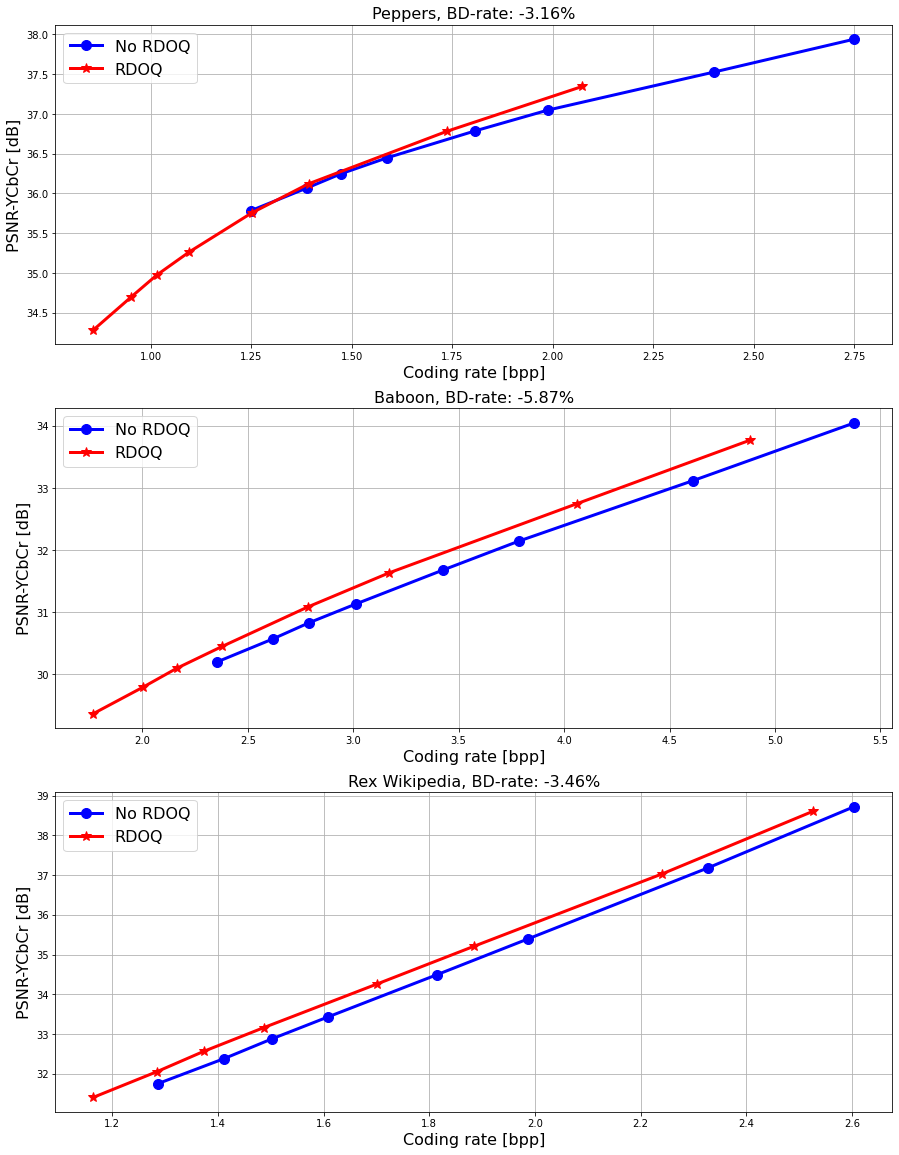

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))
titles = ["Peppers", "Baboon", "Rex Wikipedia"]

for image_idx in range(len(images)):
    ax = plt.subplot(len(images), 1, image_idx + 1)
    plt.plot(bpp_default[image_idx, :], psnr_default[image_idx, :], "b-o", linewidth=3, markersize=10, label="No RDOQ")
    plt.plot(bpp_opt[image_idx, :], psnr_opt[image_idx, :], "r-*", linewidth=3, markersize=10, label="RDOQ")
    plt.grid()
    plt.legend(prop={'size': 16})
    plt.xlabel("Coding rate [bpp]", fontsize=16)
    plt.ylabel("PSNR-YCbCr [dB]", fontsize=16)
    final_title = f"{titles[image_idx]}, BD-rate: {bd_rate_values[image_idx]:.2f}%"
    ax.set_title(final_title, fontsize=16)

In [ ]:
import numpy as np
from encoder_rdoq import jpeg_encoding_rdoq
import cv2
from ct import rgb_to_ycbcr_bt601
import os
from quantiser import compute_quantisation_matrices

lambda_y = np.zeros((100))
lambda_c = np.zeros((100))

image_name = "../../input-data/peppers.tiff"
I = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
image_ref_ycbcr = rgb_to_ycbcr_bt601(I[:, :, 0], I[:, :, 1], I[:, :, 2])
bitstream_name = "bitstream.jpg"

r_y, r_c = np.zeros((100), np.int32), np.zeros((100), np.int32)
d_y, d_c = np.zeros((100), np.float64), np.zeros((100), np.float64)

# Run the JPEG encoder for all quality levels
for q in range(1, 101):
    print(f".", end="")
    bytes_total, r_y[q-1], r_c[q-1], d_y[q-1], d_c[q-1] = jpeg_encoding_rdoq(image_ref_ycbcr, bitstream_name, q)

print("")

In [ ]:
# Compute the Lagrange multiplier and quantisation step
delta_y, delta_c = np.zeros((100)), np.zeros((100))

for i in range(1, 100):
    qy, qc = compute_quantisation_matrices(i)
    delta_y[i] = np.mean(qy)
    delta_c[i] = np.mean(qc)
    lambda_y[i] = -(d_y[i] - d_y[i - 1]) / (r_y[i] - r_y[i - 1])
    lambda_c[i] = -(d_c[i] - d_c[i - 1]) / (r_c[i] - r_c[i - 1])

In [ ]:
import matplotlib.pyplot as plt

lambda_y1 = 0.85 * np.square(delta_y)

plt.figure(figsize=(15, 15))
plt.plot(delta_y[4:], lambda_y[4:], 'r-o', label="Data-based", linewidth=2)
plt.plot(delta_y[4:], lambda_y1[4:], 'b-*', label="Canonical", linewidth=2)
plt.grid()
plt.xlabel('Quantisation step')
plt.ylabel('Lagrange multiplier')
plt.legend()
p = np.polyfit(delta_y[4:], lambda_y[4:], 2)
lambda_c[1:3] = lambda_c[3]

In [1]:
import numpy as np
from encoder import jpeg_encoding
from encoder_rdoq import jpeg_encoding_rdoq
import cv2
from ct import rgb_to_ycbcr_bt601
import os

images = ["../../input-data/peppers.tiff"]
qualities = [75, 78, 80, 82, 85, 87, 90, 92]
bitstream_name = "bitstream.jpg"
psnr_default, psnr_opt = np.zeros((len(images), len(qualities))), np.zeros((len(images), len(qualities)))
bpp_default, bpp_opt = np.zeros((len(images), len(qualities))), np.zeros((len(images), len(qualities)))

for image_idx, im in enumerate(images):
    I = cv2.imread(im, cv2.IMREAD_UNCHANGED)
    image_ref_ycbcr = rgb_to_ycbcr_bt601(I[:, :, 0], I[:, :, 1], I[:, :, 2])
    rows, cols = I.shape[0], I.shape[1]
    
    for quality_idx, q in enumerate(qualities):
        print(f"Quality: {q}")
        # JPEG no RDOQ
        bytes_total, _ = jpeg_encoding(image_ref_ycbcr, bitstream_name, q)
        image_rec = cv2.imread(bitstream_name, cv2.IMREAD_UNCHANGED).astype(np.uint8)
        image_rec_ycbcr = rgb_to_ycbcr_bt601(image_rec[:, :, 2], image_rec[:, :, 1], image_rec[:, :, 0])
        mse = 0
        for c in range(3):
            mse += np.mean(np.square(image_ref_ycbcr[:, :, c] - image_rec_ycbcr[:, :, c]))
        psnr_default[image_idx, quality_idx] = 10 * np.log10(255**2 / mse * 3)
        bpp_default[image_idx, quality_idx] = bytes_total * 8 / rows / cols

        # JPEG RDOQ
        bytes_total, _, _, _, _ = jpeg_encoding_rdoq(image_ref_ycbcr, bitstream_name, q)
        image_rec = cv2.imread(bitstream_name, cv2.IMREAD_UNCHANGED).astype(np.uint8)
        image_rec_ycbcr = rgb_to_ycbcr_bt601(image_rec[:, :, 2], image_rec[:, :, 1], image_rec[:, :, 0])
        mse = 0
        for c in range(3):
            mse += np.mean(np.square(image_ref_ycbcr[:, :, c] - image_rec_ycbcr[:, :, c]))
        psnr_opt[image_idx, quality_idx] = 10 * np.log10(255**2 / mse * 3)
        bpp_opt[image_idx, quality_idx] = bytes_total * 8 / rows / cols

os.remove(bitstream_name)

Quality: 75
Quality: 78
Quality: 80
Quality: 82
Quality: 85
Quality: 87
Quality: 90
Quality: 92


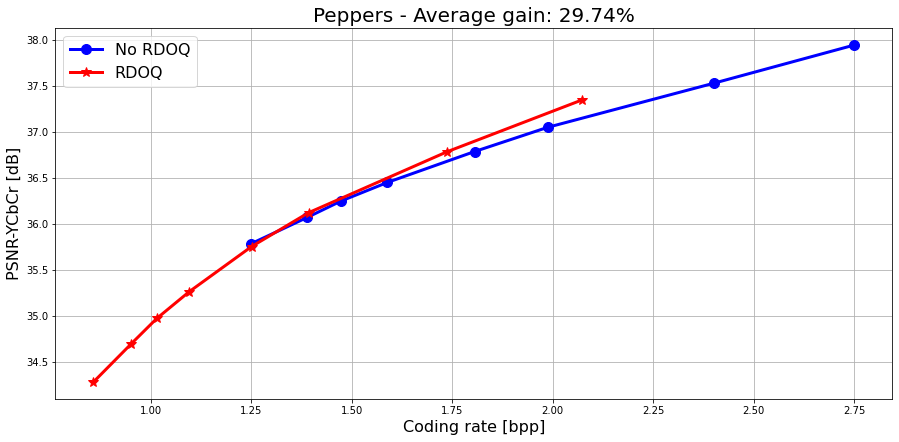

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
titles = ["Peppers"]

for image_idx in range(len(images)):
    ax = plt.subplot(2, 1, image_idx + 1)
    cr_improvement_avg = np.average(np.divide(bpp_default[image_idx, :] - bpp_opt[image_idx, :], bpp_default[image_idx, :]) * 100)
    plt.plot(bpp_default[image_idx, :], psnr_default[image_idx, :], "b-o", linewidth=3, markersize=10, label="No RDOQ")
    plt.plot(bpp_opt[image_idx, :], psnr_opt[image_idx, :], "r-*", linewidth=3, markersize=10, label="RDOQ")
    plt.grid()
    plt.legend(prop={'size': 16})
    plt.xlabel("Coding rate [bpp]", fontsize=16)
    plt.ylabel("PSNR-YCbCr [dB]", fontsize=16)
    final_title = f"{titles[image_idx]} - Average gain: {cr_improvement_avg:.2f}%"
    ax.set_title(final_title, fontsize=20)

In [ ]:
import numpy as np
from nptyping import NDArray
from typing import Any

def bdrate(ra: NDArray[(Any), np.float64], rt: NDArray[(Any), np.float64], da: NDArray[(Any), np.float64], dt: NDArray[(Any), np.float64]) -> float:
    log_ra = np.log(ra)
    log_rt = np.log(rt)

    pa = np.polyfit(da, log_ra, 3)
    pt = np.polyfit(dt, log_rt, 3)

    min_int = max(np.min(da), np.min(dt))
    max_int = min(np.max(da), np.max(dt))

    pa_int = np.polyint(pa)
    pt_int = np.polyint(pt)

    ia = np.polyval(pa_int, max_int) - np.polyval(pa_int, min_int)
    it = np.polyval(pt_int, max_int) - np.polyval(pt_int, min_int)

    diff_e = (it - ia) / (max_int - min_int)
    diff = (np.exp(diff_e) - 1) * 100

    return diff


bd_rate = bdrate(bpp_default[0, :], bpp_opt[0, :], psnr_default[0, :], psnr_opt[0, :])